# Effects of molecular noise on cell size control


## Setup

### Import and Initialise


In [2]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy

In [3]:
np.random.seed(42)

### Simulation Utilities

In [4]:
# Simulation Parameters
x_start = 0  # Initial molecule number
s_start = 8  # Initial cell size
alpha = 0.1  # Growth rate

n_lineages = 800 #number of lineages
n_steps = 10000 # simulation steps
n_observables_time_series = 3 #number of observables
n_observables_division = 7 #number of observables t_div, tau, x_o, x_f, s_o, s_f, x_*

#Configure the physical constants nu, mu, lambda
nu, mu, lambda_ = 0.0, 0.5, 0.0

In [5]:
def gillespie_algorithm_step(t, x, s, nu=1.0, mu=0.1, lambda_=0.01, alpha=0.1):

  # Calculate reaction rates
  r_production = nu + mu * s  # Production rate
  r_degradation = lambda_ * x  # Degradation rate
  r_total = r_production + r_degradation

  # Generate random numbers
  r1 = np.random.random()
  r2 = np.random.random()

  #print("Gillespie - " + "r1: " + str(r1) + "r2: " + str(r2))

  # Calculate time to next reaction
  tau = - np.log(r1) / r_total #exponential distribution of the waiting time

  # Update time and cell size
  t += tau
  s *= np.exp(alpha * tau)

  # Determine which reaction occurs
  if r_production > r2 * r_total:
      x += 1  # Production
  else:
      x -= 1  # Degradation

  #print("Gillespie - " + "tau: " + str(tau) + "time: " + str(t) + ", molecules: " + str(x) + ", size: " + str(s))
  # Return values
  return t, x, s

def deterministic_evolution_step(t, x, s, nu=1.0, mu=0.1, lambda_=0.01, alpha=0.1):
  _dt = 1 / (nu  + mu * s - lambda_ * x)
  t += 1 / (nu  + mu * s - lambda_ * x)
  x += 1 / (nu  + mu * s - lambda_ * x)
  s *= np.exp(alpha * _dt)

  # Return values
  return t, x, s

In [6]:
def simulation(
    molecular_dynamics = "deterministic",
    molecular_threshold = "deterministic",
    reset = 0,
    burn_in = 0,
    x_start = x_start,
    x_thresh = 2 * x_start,
    x_abs_noise = 0.2 * x_start,
    s_start = s_start,
    alpha = alpha,
    n_lineages = n_lineages,
    n_steps = n_steps,
    n_observables_time_series = n_observables_time_series,
    n_observables_division = n_observables_division,
    nu = nu,
    mu = mu,
    lambda_ = lambda_):


  # Initialise data structures
  lineages_time_series = np.zeros(( n_lineages, n_steps, n_observables_time_series))
  data_divisions = np.zeros(( n_observables_division, 1))



  division_index = 1

  for j in range(n_lineages):

    t = 0
    x = x_start
    s = s_start

    # Initialize variables
    t_values = [t]
    x_values = [x]
    s_values = [s]

    #print(t_values)
    #print(x_values)
    #print(s_values)

    data_divisions = np.column_stack((data_divisions, np.array([0,0,x,0,s,0,0])))

    _first_division = True

    #set the first threshold
    if molecular_threshold == "deterministic":
      x_thresh_samp = x_thresh
    else:
      x_thresh_samp = np.random.normal(loc = x_thresh, scale = x_abs_noise)

    for k in range(n_steps - 1):

      #toggle to choose between stochastic and deterministic x evolution
      if molecular_dynamics == "deterministic":
        t, x, s = deterministic_evolution_step(t, x, s, nu=nu, mu=mu, lambda_=lambda_, alpha=alpha)
      else:
        t, x, s = gillespie_algorithm_step(t, x, s, nu=nu, mu=mu, lambda_=lambda_, alpha=alpha)



      t_values.append(t)
      x_values.append(x)
      s_values.append(s)

      burn_in -= 1
      #print(burn_in)

      if x > x_thresh_samp:

        x = x * reset
        s = s/2

        if burn_in <= 0:
          #complete the current division
          if _first_division:
            data_divisions[1, division_index] = t
            _first_division = False
          else:
            data_divisions[1, division_index] = t - data_divisions[0, division_index - 1]
          data_divisions[0, division_index] = t
          data_divisions[3, division_index] = x / reset
          data_divisions[5, division_index] = s * 2
          data_divisions[6, division_index] = x_thresh_samp
          division_index += 1

          #initialize the next division
          data_divisions = np.column_stack((data_divisions, np.array([0,0,x,0,s,0,0])))

        #set next threshold
        if molecular_threshold == "deterministic":
          x_thresh_samp = x_thresh
        else:
          x_thresh_samp = np.random.normal(loc = x_thresh, scale = x_abs_noise)

    data_divisions = data_divisions[:,:-1]
    lineages_time_series[j,:,:] = np.stack((t_values, x_values, s_values), axis= -1)


  data_divisions = data_divisions[:,1:]

  return lineages_time_series, data_divisions


In [7]:
def plot_time_series(lineages_time_series):
  fig, axes = plt.subplots(1, 2, figsize=(15, 6))

  axes[0].set_title('molecule number time series ')
  axes[1].set_title('cell size time series')

  for j in range(lineages_time_series.shape[0]):
    axes[0].plot(lineages_time_series[j,:,0], lineages_time_series[j,:,1])
    axes[1].plot(lineages_time_series[j,:,0], lineages_time_series[j,:,2])

  plt.show()

## Simulation Adder (Det,Sto)^2 reset a 0


### Default Simulation Parameters


In [ ]:
# Simulation Parameters
x_start = 0  # Initial molecule number
s_start = 8  # Initial cell size
alpha = 0.1  # Growth rate

n_lineages = 800 #number of lineages
n_steps = 10000 # simulation steps
n_observables_time_series = 3 #number of observables
n_observables_division = 7 #number of observables t_div, tau, x_o, x_f, s_o, s_f, x_*

#Configure the physical constants nu, mu, lambda
nu, mu, lambda_ = 0.0, 0.5, 0.0

### Actual Simulation

In [ ]:
lineages_time_series, data_divisions  = simulation(molecular_dynamics = "deterministic", molecular_threshold = "deterministic", reset = 0, n_steps = n_steps)
data_divisions_dict = {
    't_div': data_divisions[0,:],
    'tau': data_divisions[1,:],
    'x_o': data_divisions[2,:],
    'x_f': data_divisions[3,:],
    's_o': data_divisions[4,:],
    's_f': data_divisions[5,:],
    'x_*': data_divisions[6,:],
    'Delta-s' : data_divisions[5,:] - data_divisions[4,:],
    'log-s' : np.log(data_divisions[4,:]),
    'alpha-tau' :  data_divisions[1,:] * alpha,
    'eps_n' : np.log(data_divisions[4,:]/np.mean(data_divisions[4,:])),
    'delta_n' : alpha * data_divisions[1,:] - np.log(2)
}
df = pd.DataFrame(data_divisions_dict)
df.to_csv('data_det_det_0.csv', index=False)

KeyboardInterrupt: 

In [ ]:
plot_time_series(lineages_time_series)

In [ ]:
lineages_time_series, data_divisions  = simulation(molecular_dynamics = "deterministic", molecular_threshold = "stochastic", reset = 0, n_steps = n_steps)
print('ltime series shape: \n',lineages_time_series.shape,'data divisions shape: \n', data_divisions.shape)
data_divisions_dict = {
    't_div': data_divisions[0,:],
    'tau': data_divisions[1,:],
    'x_o': data_divisions[2,:],
    'x_f': data_divisions[3,:],
    's_o': data_divisions[4,:],
    's_f': data_divisions[5,:],
    'x_*': data_divisions[6,:],
    'Delta-s' : data_divisions[5,:] - data_divisions[4,:],
    'log-s' : np.log(data_divisions[4,:]),
    'alpha-tau' :  data_divisions[1,:] * alpha,
    'eps_n' : np.log(data_divisions[4,:]/np.mean(data_divisions[4,:])),
    'delta_n' : alpha * data_divisions[1,:] - np.log(2)
}
df = pd.DataFrame(data_divisions_dict)
df.to_csv('data_det_sto_0.csv', index=False)

In [ ]:
plot_time_series(lineages_time_series)

In [ ]:
lineages_time_series, data_divisions  = simulation(molecular_dynamics = "stochastic", molecular_threshold = "deterministic", reset = 0, n_steps = n_steps)
print('ltime series shape: \n',lineages_time_series.shape,'data divisions shape: \n', data_divisions.shape)
data_divisions_dict = {
    't_div': data_divisions[0,:],
    'tau': data_divisions[1,:],
    'x_o': data_divisions[2,:],
    'x_f': data_divisions[3,:],
    's_o': data_divisions[4,:],
    's_f': data_divisions[5,:],
    'x_*': data_divisions[6,:],
    'Delta-s' : data_divisions[5,:] - data_divisions[4,:],
    'log-s' : np.log(data_divisions[4,:]),
    'alpha-tau' :  data_divisions[1,:] * alpha,
    'eps_n' : np.log(data_divisions[4,:]/np.mean(data_divisions[4,:])),
    'delta_n' : alpha * data_divisions[1,:] - np.log(2)
}
df = pd.DataFrame(data_divisions_dict)
df.to_csv('data_sto_det_0.csv', index=False)

In [ ]:
plot_time_series(lineages_time_series)

In [ ]:
lineages_time_series, data_divisions  = simulation(molecular_dynamics = "stochastic", molecular_threshold = "stochastic", reset = 0, n_steps = n_steps)
print('ltime series shape: \n',lineages_time_series.shape,'data divisions shape: \n', data_divisions.shape)
data_divisions_dict = {
    't_div': data_divisions[0,:],
    'tau': data_divisions[1,:],
    'x_o': data_divisions[2,:],
    'x_f': data_divisions[3,:],
    's_o': data_divisions[4,:],
    's_f': data_divisions[5,:],
    'x_*': data_divisions[6,:],
    'Delta-s' : data_divisions[5,:] - data_divisions[4,:],
    'log-s' : np.log(data_divisions[4,:]),
    'alpha-tau' :  data_divisions[1,:] * alpha,
    'eps_n' : np.log(data_divisions[4,:]/np.mean(data_divisions[4,:])),
    'delta_n' : alpha * data_divisions[1,:] - np.log(2)
}
df = pd.DataFrame(data_divisions_dict)
df.to_csv('data_sto_sto_0.csv', index=False)

In [ ]:
plot_time_series(lineages_time_series)

### Plot Det Det

In [ ]:
data_divisions_df = pd.read_csv('data_det_det_0.csv')


#plot scatterplots

fig, axes = plt.subplots(2, 3, figsize=(21, 15))



##
axes[0,0].set_title('birth-division size scatterplot')
axes[0,0].scatter(data_divisions_df['s_o'], data_divisions_df['s_f'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['s_f'])
axes[0,0].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,0].text(0.05, 0.95, coeff_text, transform=axes[0,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,0].set_xlabel('Birth Size')
axes[0,0].set_ylabel('Division Size')

##
axes[0,1].set_title('birth-delta size scatterplot')
axes[0,1].scatter(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
axes[0,1].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,1].text(0.05, 0.95, coeff_text, transform=axes[0,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,1].set_xlabel('Birth Size')
axes[0,1].set_ylabel('Delta Size')

##
axes[0,2].set_title('birth-division size scatterplot')
axes[0,2].scatter(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
regression = scipy.stats.linregress(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
axes[0,2].plot(data_divisions_df['log-s'], regression.slope * data_divisions_df['log-s'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,2].text(0.05, 0.95, coeff_text, transform=axes[0,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,2].set_xlabel('Log Birth Size')
axes[0,2].set_ylabel('Alpha-Tau')

##
axes[1,0].set_title('birth size histogram')
axes[1,0].hist(data_divisions_df['s_o'])

coeff_text = f'Mean: {np.mean(data_divisions_df["s_o"]):.4f}\n Std: {np.std(data_divisions_df["s_o"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["s_o"]))/np.mean(data_divisions_df["s_o"]):.4f}'
axes[1,0].text(0.05, 0.95, coeff_text, transform=axes[1,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,1].set_title('tau histogram')
axes[1,1].hist(data_divisions_df['tau'])

coeff_text = f'Mean: {np.mean(data_divisions_df["tau"]):.4f}\n Std: {np.std(data_divisions_df["tau"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["tau"]))/np.mean(data_divisions_df["tau"]):.4f}'
axes[1,1].text(0.05, 0.95, coeff_text, transform=axes[1,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,2].set_title('delta size histogram')
axes[1,2].hist(data_divisions_df['Delta-s'])

coeff_text = f'Mean: {np.mean(data_divisions_df["Delta-s"]):.4f}\n Std: {np.std(data_divisions_df["Delta-s"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["Delta-s"]))/np.mean(data_divisions_df["Delta-s"]):.4f}'
axes[1,2].text(0.05, 0.95, coeff_text, transform=axes[1,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


plt.show()

### Plot Det Sto


In [ ]:
data_divisions_df = pd.read_csv('data_det_sto_0.csv')


#plot scatterplots

fig, axes = plt.subplots(2, 3, figsize=(21, 15))



##
axes[0,0].set_title('birth-division size scatterplot')
axes[0,0].scatter(data_divisions_df['s_o'], data_divisions_df['s_f'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['s_f'])
axes[0,0].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,0].text(0.05, 0.95, coeff_text, transform=axes[0,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,0].set_xlabel('Birth Size')
axes[0,0].set_ylabel('Division Size')

##
axes[0,1].set_title('birth-delta size scatterplot')
axes[0,1].scatter(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
axes[0,1].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,1].text(0.05, 0.95, coeff_text, transform=axes[0,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,1].set_xlabel('Birth Size')
axes[0,1].set_ylabel('Delta Size')

##
axes[0,2].set_title('birth-division size scatterplot')
axes[0,2].scatter(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
regression = scipy.stats.linregress(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
axes[0,2].plot(data_divisions_df['log-s'], regression.slope * data_divisions_df['log-s'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,2].text(0.05, 0.95, coeff_text, transform=axes[0,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,2].set_xlabel('Log Birth Size')
axes[0,2].set_ylabel('Alpha-Tau')

##
axes[1,0].set_title('birth size histogram')
axes[1,0].hist(data_divisions_df['s_o'])

coeff_text = f'Mean: {np.mean(data_divisions_df["s_o"]):.4f}\n Std: {np.std(data_divisions_df["s_o"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["s_o"]))/np.mean(data_divisions_df["s_o"]):.4f}'
axes[1,0].text(0.05, 0.95, coeff_text, transform=axes[1,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,1].set_title('tau histogram')
axes[1,1].hist(data_divisions_df['tau'])

coeff_text = f'Mean: {np.mean(data_divisions_df["tau"]):.4f}\n Std: {np.std(data_divisions_df["tau"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["tau"]))/np.mean(data_divisions_df["tau"]):.4f}'
axes[1,1].text(0.05, 0.95, coeff_text, transform=axes[1,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,2].set_title('delta size histogram')
axes[1,2].hist(data_divisions_df['Delta-s'])

coeff_text = f'Mean: {np.mean(data_divisions_df["Delta-s"]):.4f}\n Std: {np.std(data_divisions_df["Delta-s"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["Delta-s"]))/np.mean(data_divisions_df["Delta-s"]):.4f}'
axes[1,2].text(0.05, 0.95, coeff_text, transform=axes[1,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


plt.show()

### Plot Sto Det

In [ ]:
data_divisions_df = pd.read_csv('data_sto_det_0.csv')


#plot scatterplots

fig, axes = plt.subplots(2, 3, figsize=(21, 15))



##
axes[0,0].set_title('birth-division size scatterplot')
axes[0,0].scatter(data_divisions_df['s_o'], data_divisions_df['s_f'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['s_f'])
axes[0,0].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,0].text(0.05, 0.95, coeff_text, transform=axes[0,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,0].set_xlabel('Birth Size')
axes[0,0].set_ylabel('Division Size')

##
axes[0,1].set_title('birth-delta size scatterplot')
axes[0,1].scatter(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
axes[0,1].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,1].text(0.05, 0.95, coeff_text, transform=axes[0,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,1].set_xlabel('Birth Size')
axes[0,1].set_ylabel('Delta Size')

##
axes[0,2].set_title('birth-division size scatterplot')
axes[0,2].scatter(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
regression = scipy.stats.linregress(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
axes[0,2].plot(data_divisions_df['log-s'], regression.slope * data_divisions_df['log-s'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,2].text(0.05, 0.95, coeff_text, transform=axes[0,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,2].set_xlabel('Log Birth Size')
axes[0,2].set_ylabel('Alpha-Tau')

##
axes[1,0].set_title('birth size histogram')
axes[1,0].hist(data_divisions_df['s_o'])

coeff_text = f'Mean: {np.mean(data_divisions_df["s_o"]):.4f}\n Std: {np.std(data_divisions_df["s_o"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["s_o"]))/np.mean(data_divisions_df["s_o"]):.4f}'
axes[1,0].text(0.05, 0.95, coeff_text, transform=axes[1,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,1].set_title('tau histogram')
axes[1,1].hist(data_divisions_df['tau'])

coeff_text = f'Mean: {np.mean(data_divisions_df["tau"]):.4f}\n Std: {np.std(data_divisions_df["tau"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["tau"]))/np.mean(data_divisions_df["tau"]):.4f}'
axes[1,1].text(0.05, 0.95, coeff_text, transform=axes[1,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,2].set_title('delta size histogram')
axes[1,2].hist(data_divisions_df['Delta-s'])

coeff_text = f'Mean: {np.mean(data_divisions_df["Delta-s"]):.4f}\n Std: {np.std(data_divisions_df["Delta-s"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["Delta-s"]))/np.mean(data_divisions_df["Delta-s"]):.4f}'
axes[1,2].text(0.05, 0.95, coeff_text, transform=axes[1,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


plt.show()

### Plot Sto Sto


In [ ]:
data_divisions_df = pd.read_csv('data_sto_sto_0.csv')

#plot scatterplots

fig, axes = plt.subplots(2, 3, figsize=(21, 15))



##
axes[0,0].set_title('birth-division size scatterplot')
axes[0,0].scatter(data_divisions_df['s_o'], data_divisions_df['s_f'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['s_f'])
axes[0,0].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,0].text(0.05, 0.95, coeff_text, transform=axes[0,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,0].set_xlabel('Birth Size')
axes[0,0].set_ylabel('Division Size')

##
axes[0,1].set_title('birth-delta size scatterplot')
axes[0,1].scatter(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
axes[0,1].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,1].text(0.05, 0.95, coeff_text, transform=axes[0,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,1].set_xlabel('Birth Size')
axes[0,1].set_ylabel('Delta Size')

##
axes[0,2].set_title('birth-division size scatterplot')
axes[0,2].scatter(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
regression = scipy.stats.linregress(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
axes[0,2].plot(data_divisions_df['log-s'], regression.slope * data_divisions_df['log-s'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,2].text(0.05, 0.95, coeff_text, transform=axes[0,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,2].set_xlabel('Log Birth Size')
axes[0,2].set_ylabel('Alpha-Tau')

##
axes[1,0].set_title('birth size histogram')
axes[1,0].hist(data_divisions_df['s_o'])

coeff_text = f'Mean: {np.mean(data_divisions_df["s_o"]):.4f}\n Std: {np.std(data_divisions_df["s_o"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["s_o"]))/np.mean(data_divisions_df["s_o"]):.4f}'
axes[1,0].text(0.05, 0.95, coeff_text, transform=axes[1,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,1].set_title('tau histogram')
axes[1,1].hist(data_divisions_df['tau'])

coeff_text = f'Mean: {np.mean(data_divisions_df["tau"]):.4f}\n Std: {np.std(data_divisions_df["tau"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["tau"]))/np.mean(data_divisions_df["tau"]):.4f}'
axes[1,1].text(0.05, 0.95, coeff_text, transform=axes[1,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,2].set_title('delta size histogram')
axes[1,2].hist(data_divisions_df['Delta-s'])

coeff_text = f'Mean: {np.mean(data_divisions_df["Delta-s"]):.4f}\n Std: {np.std(data_divisions_df["Delta-s"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["Delta-s"]))/np.mean(data_divisions_df["Delta-s"]):.4f}'
axes[1,2].text(0.05, 0.95, coeff_text, transform=axes[1,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


plt.show()

## Simulation Adder (Det,Sto)^2 reset a x/2


### Default Simulation Parameters


In [ ]:
# Simulation Parameters
x_start = 25  # Initial molecule number
s_start = 8  # Initial cell size
alpha = 0.1  # Growth rate

n_lineages = 800 #number of lineages
n_steps = 10000 # simulation steps
n_observables_time_series = 3 #number of observables
n_observables_division = 7 #number of observables t_div, tau, x_o, x_f, s_o, s_f, x_*

#Configure the physical constants nu, mu, lambda
nu, mu, lambda_ = 0.0, 0.5, 0.0

### Actual Simulation

In [ ]:
lineages_time_series, data_divisions  = simulation(molecular_dynamics = "deterministic", molecular_threshold = "deterministic", reset = 0.5, n_steps = n_steps)
print('ltime series shape: \n',lineages_time_series.shape,'data divisions shape: \n', data_divisions.shape)
data_divisions_dict = {
    't_div': data_divisions[0,:],
    'tau': data_divisions[1,:],
    'x_o': data_divisions[2,:],
    'x_f': data_divisions[3,:],
    's_o': data_divisions[4,:],
    's_f': data_divisions[5,:],
    'x_*': data_divisions[6,:],
    'Delta-s' : data_divisions[5,:] - data_divisions[4,:],
    'log-s' : np.log(data_divisions[4,:]),
    'alpha-tau' :  data_divisions[1,:] * alpha,
    'eps_n' : np.log(data_divisions[4,:]/np.mean(data_divisions[4,:])),
    'delta_n' : alpha * data_divisions[1,:] - np.log(2)
}
df = pd.DataFrame(data_divisions_dict)
df.to_csv('data_det_det_0.csv', index=False)

In [ ]:
plot_time_series(lineages_time_series)

In [ ]:
lineages_time_series, data_divisions  = simulation(molecular_dynamics = "deterministic", molecular_threshold = "stochastic", reset = 0.5, n_steps = n_steps)
print('ltime series shape: \n',lineages_time_series.shape,'data divisions shape: \n', data_divisions.shape)
data_divisions_dict = {
    't_div': data_divisions[0,:],
    'tau': data_divisions[1,:],
    'x_o': data_divisions[2,:],
    'x_f': data_divisions[3,:],
    's_o': data_divisions[4,:],
    's_f': data_divisions[5,:],
    'x_*': data_divisions[6,:],
    'Delta-s' : data_divisions[5,:] - data_divisions[4,:],
    'log-s' : np.log(data_divisions[4,:]),
    'alpha-tau' :  data_divisions[1,:] * alpha,
    'eps_n' : np.log(data_divisions[4,:]/np.mean(data_divisions[4,:])),
    'delta_n' : alpha * data_divisions[1,:] - np.log(2)
}
df = pd.DataFrame(data_divisions_dict)
df.to_csv('data_det_sto_0.csv', index=False)

In [ ]:
plot_time_series(lineages_time_series)

In [ ]:
lineages_time_series, data_divisions  = simulation(molecular_dynamics = "stochastic", molecular_threshold = "deterministic", reset = 0.5, n_steps = n_steps)
print('ltime series shape: \n',lineages_time_series.shape,'data divisions shape: \n', data_divisions.shape)
data_divisions_dict = {
    't_div': data_divisions[0,:],
    'tau': data_divisions[1,:],
    'x_o': data_divisions[2,:],
    'x_f': data_divisions[3,:],
    's_o': data_divisions[4,:],
    's_f': data_divisions[5,:],
    'x_*': data_divisions[6,:],
    'Delta-s' : data_divisions[5,:] - data_divisions[4,:],
    'log-s' : np.log(data_divisions[4,:]),
    'alpha-tau' :  data_divisions[1,:] * alpha,
    'eps_n' : np.log(data_divisions[4,:]/np.mean(data_divisions[4,:])),
    'delta_n' : alpha * data_divisions[1,:] - np.log(2)
}
df = pd.DataFrame(data_divisions_dict)
df.to_csv('data_sto_det_0.csv', index=False)

In [ ]:
plot_time_series(lineages_time_series)

In [ ]:
lineages_time_series, data_divisions  = simulation(molecular_dynamics = "stochastic", molecular_threshold = "stochastic", reset = 0.5, n_steps = n_steps)
print('ltime series shape: \n',lineages_time_series.shape,'data divisions shape: \n', data_divisions.shape)
data_divisions_dict = {
    't_div': data_divisions[0,:],
    'tau': data_divisions[1,:],
    'x_o': data_divisions[2,:],
    'x_f': data_divisions[3,:],
    's_o': data_divisions[4,:],
    's_f': data_divisions[5,:],
    'x_*': data_divisions[6,:],
    'Delta-s' : data_divisions[5,:] - data_divisions[4,:],
    'log-s' : np.log(data_divisions[4,:]),
    'alpha-tau' :  data_divisions[1,:] * alpha,
    'eps_n' : np.log(data_divisions[4,:]/np.mean(data_divisions[4,:])),
    'delta_n' : alpha * data_divisions[1,:] - np.log(2)
}
df = pd.DataFrame(data_divisions_dict)
df.to_csv('data_sto_sto_0.csv', index=False)

In [ ]:
plot_time_series(lineages_time_series)

### Plot Det Det

In [ ]:
data_divisions_df = pd.read_csv('data_det_det_0.csv')


#plot scatterplots

fig, axes = plt.subplots(2, 3, figsize=(21, 15))



##
axes[0,0].set_title('birth-division size scatterplot')
axes[0,0].scatter(data_divisions_df['s_o'], data_divisions_df['s_f'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['s_f'])
axes[0,0].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,0].text(0.05, 0.95, coeff_text, transform=axes[0,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,0].set_xlabel('Birth Size')
axes[0,0].set_ylabel('Division Size')

##
axes[0,1].set_title('birth-delta size scatterplot')
axes[0,1].scatter(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
axes[0,1].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,1].text(0.05, 0.95, coeff_text, transform=axes[0,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,1].set_xlabel('Birth Size')
axes[0,1].set_ylabel('Delta Size')

##
axes[0,2].set_title('birth-division size scatterplot')
axes[0,2].scatter(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
regression = scipy.stats.linregress(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
axes[0,2].plot(data_divisions_df['log-s'], regression.slope * data_divisions_df['log-s'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,2].text(0.05, 0.95, coeff_text, transform=axes[0,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,2].set_xlabel('Log Birth Size')
axes[0,2].set_ylabel('Alpha-Tau')

##
axes[1,0].set_title('birth size histogram')
axes[1,0].hist(data_divisions_df['s_o'])

coeff_text = f'Mean: {np.mean(data_divisions_df["s_o"]):.4f}\n Std: {np.std(data_divisions_df["s_o"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["s_o"]))/np.mean(data_divisions_df["s_o"]):.4f}'
axes[1,0].text(0.05, 0.95, coeff_text, transform=axes[1,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,1].set_title('tau histogram')
axes[1,1].hist(data_divisions_df['tau'])

coeff_text = f'Mean: {np.mean(data_divisions_df["tau"]):.4f}\n Std: {np.std(data_divisions_df["tau"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["tau"]))/np.mean(data_divisions_df["tau"]):.4f}'
axes[1,1].text(0.05, 0.95, coeff_text, transform=axes[1,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,2].set_title('delta size histogram')
axes[1,2].hist(data_divisions_df['Delta-s'])

coeff_text = f'Mean: {np.mean(data_divisions_df["Delta-s"]):.4f}\n Std: {np.std(data_divisions_df["Delta-s"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["Delta-s"]))/np.mean(data_divisions_df["Delta-s"]):.4f}'
axes[1,2].text(0.05, 0.95, coeff_text, transform=axes[1,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


plt.show()

### Plot Det Sto


In [ ]:
data_divisions_df = pd.read_csv('data_det_sto_0.csv')


#plot scatterplots

fig, axes = plt.subplots(2, 3, figsize=(21, 15))



##
axes[0,0].set_title('birth-division size scatterplot')
axes[0,0].scatter(data_divisions_df['s_o'], data_divisions_df['s_f'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['s_f'])
axes[0,0].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,0].text(0.05, 0.95, coeff_text, transform=axes[0,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,0].set_xlabel('Birth Size')
axes[0,0].set_ylabel('Division Size')

##
axes[0,1].set_title('birth-delta size scatterplot')
axes[0,1].scatter(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
axes[0,1].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,1].text(0.05, 0.95, coeff_text, transform=axes[0,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,1].set_xlabel('Birth Size')
axes[0,1].set_ylabel('Delta Size')

##
axes[0,2].set_title('birth-division size scatterplot')
axes[0,2].scatter(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
regression = scipy.stats.linregress(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
axes[0,2].plot(data_divisions_df['log-s'], regression.slope * data_divisions_df['log-s'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,2].text(0.05, 0.95, coeff_text, transform=axes[0,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,2].set_xlabel('Log Birth Size')
axes[0,2].set_ylabel('Alpha-Tau')

##
axes[1,0].set_title('birth size histogram')
axes[1,0].hist(data_divisions_df['s_o'])

coeff_text = f'Mean: {np.mean(data_divisions_df["s_o"]):.4f}\n Std: {np.std(data_divisions_df["s_o"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["s_o"]))/np.mean(data_divisions_df["s_o"]):.4f}'
axes[1,0].text(0.05, 0.95, coeff_text, transform=axes[1,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,1].set_title('tau histogram')
axes[1,1].hist(data_divisions_df['tau'])

coeff_text = f'Mean: {np.mean(data_divisions_df["tau"]):.4f}\n Std: {np.std(data_divisions_df["tau"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["tau"]))/np.mean(data_divisions_df["tau"]):.4f}'
axes[1,1].text(0.05, 0.95, coeff_text, transform=axes[1,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,2].set_title('delta size histogram')
axes[1,2].hist(data_divisions_df['Delta-s'])

coeff_text = f'Mean: {np.mean(data_divisions_df["Delta-s"]):.4f}\n Std: {np.std(data_divisions_df["Delta-s"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["Delta-s"]))/np.mean(data_divisions_df["Delta-s"]):.4f}'
axes[1,2].text(0.05, 0.95, coeff_text, transform=axes[1,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


plt.show()

### Plot Sto Det

In [ ]:
data_divisions_df = pd.read_csv('data_sto_det_0.csv')


#plot scatterplots

fig, axes = plt.subplots(2, 3, figsize=(21, 15))



##
axes[0,0].set_title('birth-division size scatterplot')
axes[0,0].scatter(data_divisions_df['s_o'], data_divisions_df['s_f'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['s_f'])
axes[0,0].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,0].text(0.05, 0.95, coeff_text, transform=axes[0,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,0].set_xlabel('Birth Size')
axes[0,0].set_ylabel('Division Size')

##
axes[0,1].set_title('birth-delta size scatterplot')
axes[0,1].scatter(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
axes[0,1].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,1].text(0.05, 0.95, coeff_text, transform=axes[0,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,1].set_xlabel('Birth Size')
axes[0,1].set_ylabel('Delta Size')

##
axes[0,2].set_title('birth-division size scatterplot')
axes[0,2].scatter(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
regression = scipy.stats.linregress(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
axes[0,2].plot(data_divisions_df['log-s'], regression.slope * data_divisions_df['log-s'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,2].text(0.05, 0.95, coeff_text, transform=axes[0,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,2].set_xlabel('Log Birth Size')
axes[0,2].set_ylabel('Alpha-Tau')

##
axes[1,0].set_title('birth size histogram')
axes[1,0].hist(data_divisions_df['s_o'])

coeff_text = f'Mean: {np.mean(data_divisions_df["s_o"]):.4f}\n Std: {np.std(data_divisions_df["s_o"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["s_o"]))/np.mean(data_divisions_df["s_o"]):.4f}'
axes[1,0].text(0.05, 0.95, coeff_text, transform=axes[1,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,1].set_title('tau histogram')
axes[1,1].hist(data_divisions_df['tau'])

coeff_text = f'Mean: {np.mean(data_divisions_df["tau"]):.4f}\n Std: {np.std(data_divisions_df["tau"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["tau"]))/np.mean(data_divisions_df["tau"]):.4f}'
axes[1,1].text(0.05, 0.95, coeff_text, transform=axes[1,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,2].set_title('delta size histogram')
axes[1,2].hist(data_divisions_df['Delta-s'])

coeff_text = f'Mean: {np.mean(data_divisions_df["Delta-s"]):.4f}\n Std: {np.std(data_divisions_df["Delta-s"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["Delta-s"]))/np.mean(data_divisions_df["Delta-s"]):.4f}'
axes[1,2].text(0.05, 0.95, coeff_text, transform=axes[1,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


plt.show()

### Plot Sto Sto


In [ ]:
data_divisions_df = pd.read_csv('data_sto_sto_0.csv')

#plot scatterplots

fig, axes = plt.subplots(2, 3, figsize=(21, 15))



##
axes[0,0].set_title('birth-division size scatterplot')
axes[0,0].scatter(data_divisions_df['s_o'], data_divisions_df['s_f'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['s_f'])
axes[0,0].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,0].text(0.05, 0.95, coeff_text, transform=axes[0,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,0].set_xlabel('Birth Size')
axes[0,0].set_ylabel('Division Size')

##
axes[0,1].set_title('birth-delta size scatterplot')
axes[0,1].scatter(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
regression = scipy.stats.linregress(data_divisions_df['s_o'], data_divisions_df['Delta-s'])
axes[0,1].plot(data_divisions_df['s_o'], regression.slope * data_divisions_df['s_o'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,1].text(0.05, 0.95, coeff_text, transform=axes[0,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,1].set_xlabel('Birth Size')
axes[0,1].set_ylabel('Delta Size')

##
axes[0,2].set_title('birth-division size scatterplot')
axes[0,2].scatter(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
regression = scipy.stats.linregress(data_divisions_df['log-s'], data_divisions_df['alpha-tau'])
axes[0,2].plot(data_divisions_df['log-s'], regression.slope * data_divisions_df['log-s'] + regression.intercept, color='red')

#Formatting
coeff_text = f'Slope: {regression.slope:.4f}\nIntercept: {regression.intercept:.4f}\nR-value: {regression.rvalue:.4f}\nP-value: {regression.pvalue:.4f}'
axes[0,2].text(0.05, 0.95, coeff_text, transform=axes[0,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axes[0,2].set_xlabel('Log Birth Size')
axes[0,2].set_ylabel('Alpha-Tau')

##
axes[1,0].set_title('birth size histogram')
axes[1,0].hist(data_divisions_df['s_o'])

coeff_text = f'Mean: {np.mean(data_divisions_df["s_o"]):.4f}\n Std: {np.std(data_divisions_df["s_o"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["s_o"]))/np.mean(data_divisions_df["s_o"]):.4f}'
axes[1,0].text(0.05, 0.95, coeff_text, transform=axes[1,0].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,1].set_title('tau histogram')
axes[1,1].hist(data_divisions_df['tau'])

coeff_text = f'Mean: {np.mean(data_divisions_df["tau"]):.4f}\n Std: {np.std(data_divisions_df["tau"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["tau"]))/np.mean(data_divisions_df["tau"]):.4f}'
axes[1,1].text(0.05, 0.95, coeff_text, transform=axes[1,1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

##
axes[1,2].set_title('delta size histogram')
axes[1,2].hist(data_divisions_df['Delta-s'])

coeff_text = f'Mean: {np.mean(data_divisions_df["Delta-s"]):.4f}\n Std: {np.std(data_divisions_df["Delta-s"]):.4f}\n Std/Mean: {np.sqrt(np.var(data_divisions_df["Delta-s"]))/np.mean(data_divisions_df["Delta-s"]):.4f}'
axes[1,2].text(0.05, 0.95, coeff_text, transform=axes[1,2].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


plt.show()

## Task


### Simulation

In [24]:
#df alpha, mu, sigma_x*, mean(x*)
#output beta, tau, birth_noise

#unnecessary
n_observables_time_series = 3 #number of observables
n_observables_division = 7 #number of observables t_div, tau, x_o, x_f, s_o, s_f, x_*


n_lineages = 5
n_steps = 1000

ratio_space = [0.1,0.25,0.5,0.75,1,2.5,5,7.5,10]
x_thresh_space  = [1000, 5000, 10000]
sigma_thresh_space = [ 500, 1000, 5000]

sim_data = np.zeros((len(ratio_space)*len(x_thresh_space)*len(sigma_thresh_space), 8))

#simulation
for i, (ratio, x_thresh, sigma_thresh) in enumerate(itertools.product(ratio_space, x_thresh_space, sigma_thresh_space)):

    alpha = 1
    nu, mu, _lambda = 0, alpha * ratio, 0

    lineages_time_series, data_divisions = simulation(
      molecular_dynamics = "stochastic",
      molecular_threshold = "stochastic",
      reset = 0.5,
      burn_in = 500,
      x_start = 0.5 * x_thresh,
      x_thresh = x_thresh,
      x_abs_noise = sigma_thresh,
      s_start = 20,
      alpha = alpha,
      n_lineages = n_lineages,
      n_steps = int(n_steps * x_thresh),
      n_observables_time_series = n_observables_time_series,
      n_observables_division = n_observables_division,
      nu = nu,
      mu = mu,
      lambda_ = lambda_
    )

    #plot_time_series(lineages_time_series)

    #print(len(data_divisions[1,:]))
    #print("[alpha, mu, x_thresh, sigma_thresh, beta, mean_tau, sigma_tau, birth_noise]")
    #print([alpha, mu, x_thresh, sigma_thresh])

    #estimate the resulting statistics
    beta = -1 * scipy.stats.linregress(np.log(data_divisions[4,:]), data_divisions[1,:] * alpha).slope

    mean_tau  = np.mean(data_divisions[1,:])

    birth_noise = np.std(data_divisions[4,:])/np.mean(data_divisions[4,:])

    #estimate sigma tau given x*
    _bins = np.linspace(data_divisions[6,:].min(), data_divisions[6,:].max(), 10)
    _digitized = np.digitize(data_divisions[6,:], _bins)
    _std_devs = []

    for j in range(1, len(_bins)):
        _tau_given_x_star_bin = data_divisions[1,:][_digitized == j]  # τ values where x* is in the i-th bin
        _std_devs.append(np.std(_tau_given_x_star_bin))
    sigma_tau = np.mean(_std_devs)

    #print("[beta, mean_tau, sigma_tau, birth_noise]")
    #print([beta, mean_tau, sigma_tau, birth_noise])

    #update the dataframe
    sim_data[i,:] = np.array([alpha, mu, x_thresh, sigma_thresh, beta, mean_tau, sigma_tau, birth_noise])



KeyboardInterrupt: 

In [84]:
# Convert sim_data to a DataFrame with appropriate column names
column_names = ["alpha", "mu", "x_thresh", "sigma_thresh", "beta", "mean_tau", "sigma_tau", "birth_noise"]
df = pd.DataFrame(sim_data, columns=column_names)

# Save the DataFrame to a CSV file
df.to_csv("simulation_data.csv", index=False)

### Plotting

In [34]:
df = pd.read_csv('simulation_data.csv')

Beta - Ratio

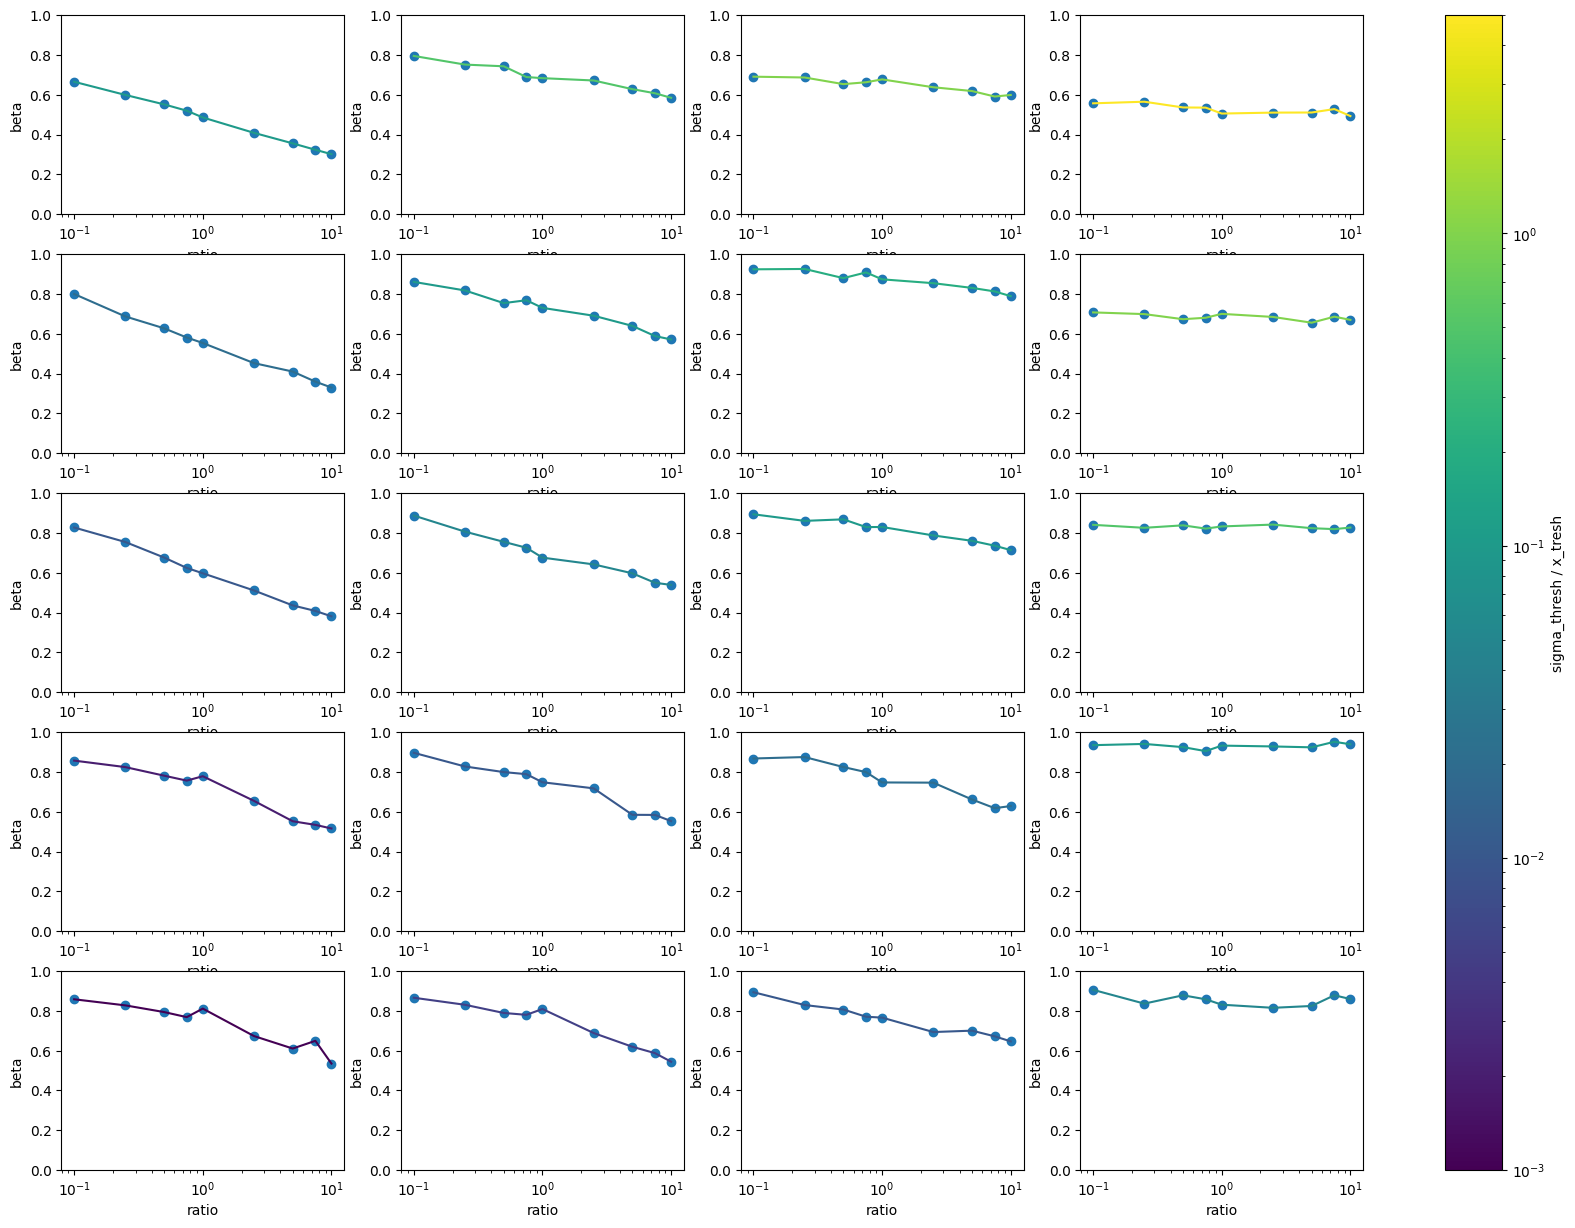

In [86]:
fig, axes = plt.subplots(5, 4, figsize=(21, 15))

norm = mpl.colors.LogNorm(vmin=0.001, vmax=5)

for i, x_thresh_val in enumerate(x_thresh_space):
  for j, sigma_thresh_val in enumerate(sigma_thresh_space):
      dff = df[df["x_thresh"] == x_thresh_val]
      dff = dff[dff["sigma_thresh"] == sigma_thresh_val]
      color_value =  sigma_thresh_val / x_thresh_val  # This is the color scale value
      ratio = dff['mu'] / dff['alpha']
      beta = dff['beta']

      axes[i,j].scatter(ratio, beta)
      axes[i,j].set_xscale('log')
      axes[i,j].set_xlabel('ratio')
      axes[i,j].set_ylabel('beta')
      axes[i, j].set_ylim(0, 1)
      axes[i,j].plot(ratio, beta, label=f'{sigma_thresh_val}/{x_thresh_val}', color=plt.cm.viridis(norm(color_value)))

      # Color based on x_thresh / sigma_thresh
      color_value =  sigma_thresh_val / x_thresh_val  # This is the color scale value


# Add a colorbar to indicate the scale of x_thresh/sigma_thresh
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])  # Empty array for colorbar
colorbar = fig.colorbar(sm, ax=axes, label="sigma_thresh / x_tresh")


plt.show()

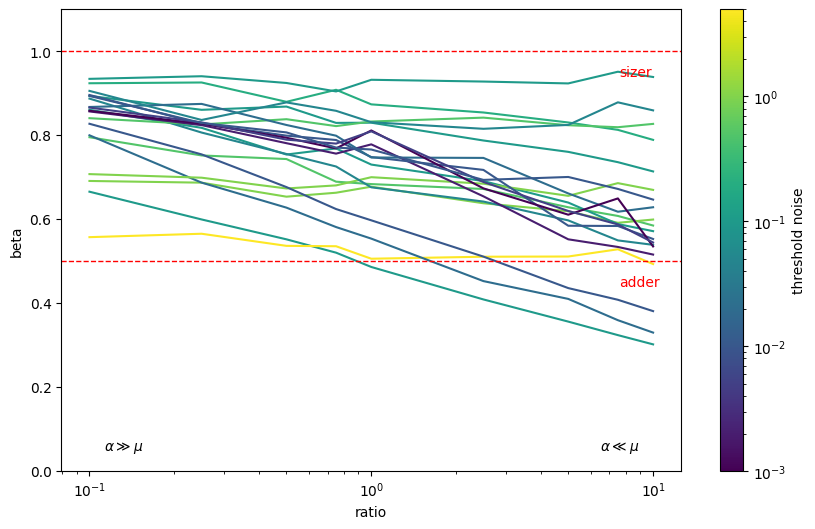

In [87]:
fig, axes = plt.subplots(figsize=(10,6))

norm = mpl.colors.LogNorm(vmin=0.001, vmax=5)

for i, x_thresh_val in enumerate(x_thresh_space):
  for j, sigma_thresh_val in enumerate(sigma_thresh_space):
      dff = df[df["x_thresh"] == x_thresh_val]
      dff = dff[dff["sigma_thresh"] == sigma_thresh_val]
      color_value =  sigma_thresh_val / x_thresh_val  # This is the color scale value
      ratio = dff['mu'] / dff['alpha']
      beta = dff['beta']

      #axes.scatter(ratio, beta, color='blue')
      axes.set_xscale('log')
      axes.set_xlabel('ratio')
      axes.set_ylabel('beta')
      axes.set_ylim(0, 1.1)
      axes.plot(ratio, beta, label=f'{sigma_thresh_val}/{x_thresh_val}', color=plt.cm.viridis(norm(color_value)))

      # Color based on x_thresh / sigma_thresh
      color_value =  sigma_thresh_val / x_thresh_val  # This is the color scale value


# Add a colorbar to indicate the scale of x_thresh/sigma_thresh
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])  # Empty array for colorbar
colorbar = fig.colorbar(sm, ax=axes, label="threshold noise")

# Add horizontal lines at y=0.5 and y=1
axes.axhline(0.5, color='red', linestyle='--', linewidth=1)
axes.axhline(1, color='red', linestyle='--', linewidth=1)
# Add text annotations for the horizontal lines
axes.text(0.90, 0.45, 'adder', color='red', verticalalignment='center', transform=axes.get_yaxis_transform())
axes.text(0.90, 0.95, 'sizer', color='red', verticalalignment='center', transform=axes.get_yaxis_transform())

axes.text(0.90, 0.05, r'$\alpha \ll \mu$', color='black', ha='center', transform=axes.get_yaxis_transform())
axes.text(0.10, 0.05, r'$\alpha \gg \mu$', color='black', ha='center', transform=axes.get_yaxis_transform())



plt.show()

Ratio - birth noise

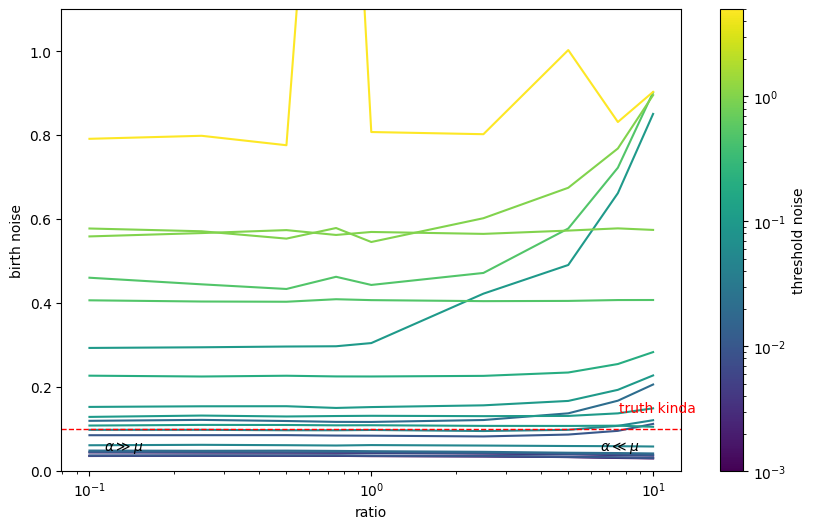

In [19]:
fig, axes = plt.subplots(figsize=(10,6))

norm = mpl.colors.LogNorm(vmin=0.001, vmax=5)

for i, x_thresh_val in enumerate(x_thresh_space):
  for j, sigma_thresh_val in enumerate(sigma_thresh_space):
      dff = df[df["x_thresh"] == x_thresh_val]
      dff = dff[dff["sigma_thresh"] == sigma_thresh_val]
      color_value =  sigma_thresh_val / x_thresh_val  # This is the color scale value
      ratio = dff['mu'] / dff['alpha']
      birth_noise = dff['birth_noise']

      #axes.scatter(ratio, beta, color='blue')
      axes.set_xscale('log')
      axes.set_xlabel('ratio')
      axes.set_ylabel('birth noise')
      #axes.set_yscale('log')
      axes.set_ylim(0, 1.1)
      axes.plot(ratio, birth_noise, label=f'{sigma_thresh_val}/{x_thresh_val}', color=plt.cm.viridis(norm(color_value)))

      # Color based on x_thresh / sigma_thresh
      color_value =  sigma_thresh_val / x_thresh_val  # This is the color scale value


# Add a colorbar to indicate the scale of x_thresh/sigma_thresh
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])  # Empty array for colorbar
colorbar = fig.colorbar(sm, ax=axes, label="threshold noise")

# Add horizontal lines at y=0.5 and y=1
axes.axhline(0.1, color='red', linestyle='--', linewidth=1)
# Add text annotations for the horizontal lines
axes.text(0.90, 0.15, 'truth kinda', color='red', verticalalignment='center', transform=axes.get_yaxis_transform())

axes.text(0.90, 0.05, r'$\alpha \ll \mu$', color='black', ha='center', transform=axes.get_yaxis_transform())
axes.text(0.10, 0.05, r'$\alpha \gg \mu$', color='black', ha='center', transform=axes.get_yaxis_transform())



plt.show()

scorporato

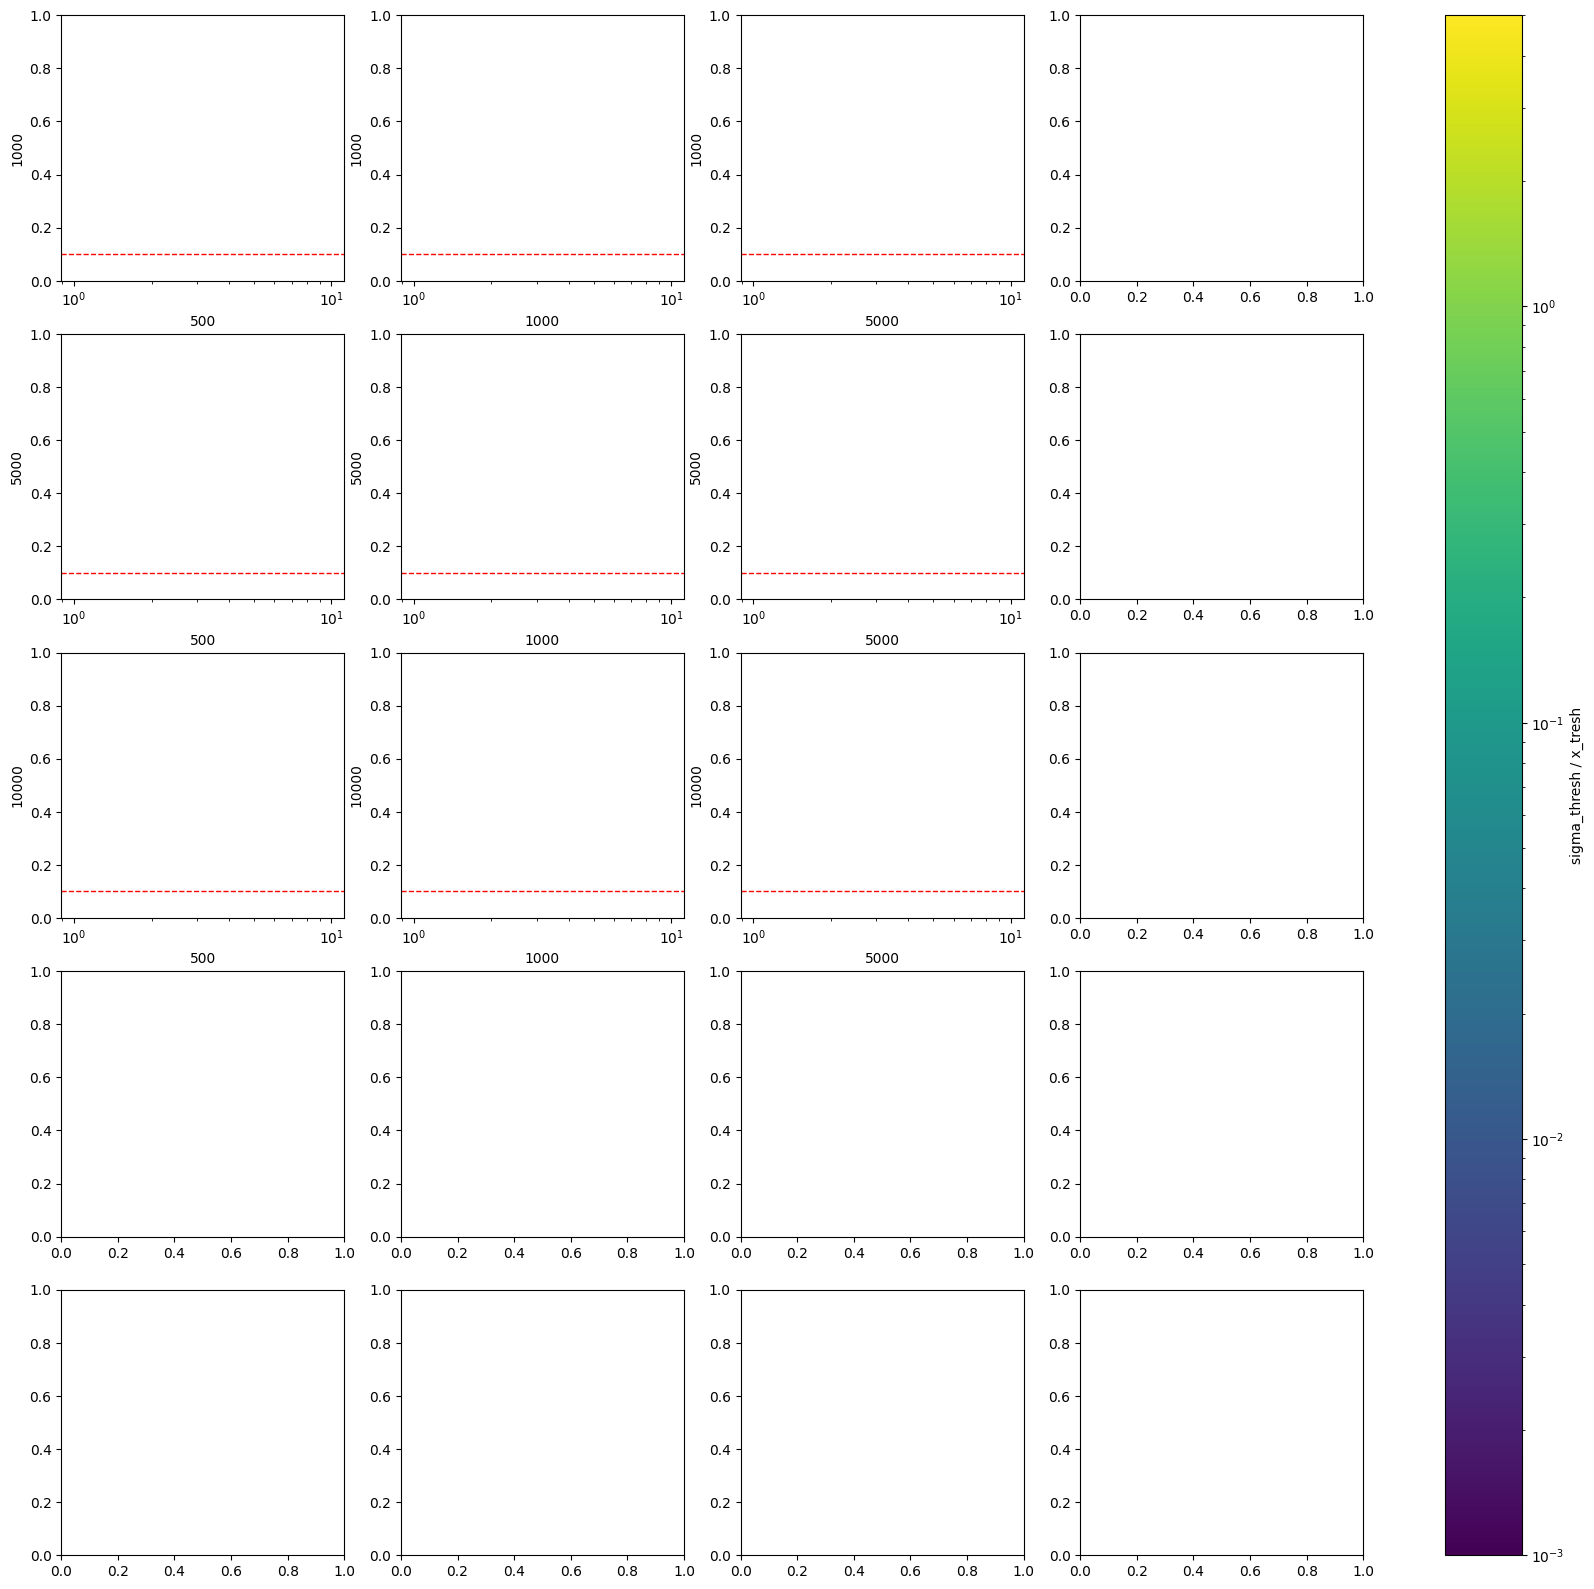

In [32]:
fig, axes = plt.subplots(5, 4, figsize=(21, 20))

norm = mpl.colors.LogNorm(vmin=0.001, vmax=5)

for i, x_thresh_val in enumerate(x_thresh_space):
  for j, sigma_thresh_val in enumerate(sigma_thresh_space):
      dff = df[df["x_thresh"] == x_thresh_val]
      dff = dff[dff["sigma_thresh"] == sigma_thresh_val]
      color_value =  sigma_thresh_val / x_thresh_val  # This is the color scale value
      ratio = dff['mu'] / dff['alpha']
      birth_noise = dff['birth_noise']

      axes[i,j].scatter(ratio, birth_noise)
      axes[i,j].set_xscale('log')
      axes[i,j].set_xlabel(sigma_thresh_val)
      #axes[i,j].set_yscale('log')
      axes[i,j].set_ylabel(x_thresh_val)
      axes[i, j].set_ylim(0, 1)
      axes[i,j].plot(ratio, birth_noise, label=f'{sigma_thresh_val}/{x_thresh_val}', color=plt.cm.viridis(norm(color_value)))

      # Color based on x_thresh / sigma_thresh
      color_value =  sigma_thresh_val / x_thresh_val  # This is the color scale value


      # Add horizontal lines at y=0.5 and y=1
      axes[i,j].axhline(0.1, color='red', linestyle='--', linewidth=1)
      # Add text annotations for the horizontal lines
      #axes[i,j].text(0.90, 0.15, 'truth kinda', color='red', verticalalignment='center', transform=axes[i,j].get_yaxis_transform())


# Add a colorbar to indicate the scale of x_thresh/sigma_thresh
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])  # Empty array for colorbar
colorbar = fig.colorbar(sm, ax=axes, label="sigma_thresh / x_tresh")


plt.show()

noise ratio - beta

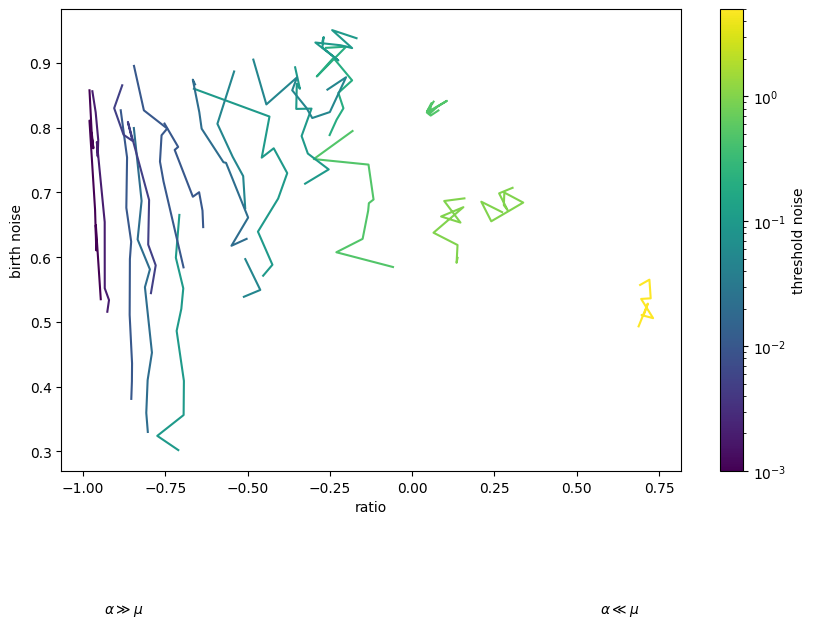

In [94]:
fig, axes = plt.subplots(figsize=(10,6))

norm = mpl.colors.LogNorm(vmin=0.001, vmax=5)

for i, x_thresh_val in enumerate(x_thresh_space):
  for j, sigma_thresh_val in enumerate(sigma_thresh_space):
      dff = df[df["x_thresh"] == x_thresh_val]
      dff = dff[dff["sigma_thresh"] == sigma_thresh_val]
      thresh_noise = sigma_thresh_val / x_thresh_val
      color_value =  thresh_noise  # This is the color scale value

      timing_noise = (dff['sigma_tau'] / dff['mean_tau'] ) # approoximate with linear growth at fixed size

      ratio = (thresh_noise - timing_noise) / (thresh_noise + timing_noise)
      beta = dff['beta']

      #axes.scatter(ratio, beta, color='blue')
      #axes.set_xscale('log')
      axes.set_xlabel('ratio')
      axes.set_ylabel('birth noise')
      #axes.set_yscale('log')
      #axes.set_ylim(0, 1.1)
      axes.plot(ratio, beta, label=f'{sigma_thresh_val}/{x_thresh_val}', color=plt.cm.viridis(norm(color_value)))

      # Color based on x_thresh / sigma_thresh
      color_value =  sigma_thresh_val / x_thresh_val  # This is the color scale value


# Add a colorbar to indicate the scale of x_thresh/sigma_thresh
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])  # Empty array for colorbar
colorbar = fig.colorbar(sm, ax=axes, label="threshold noise")

# Add horizontal lines at y=0.5 and y=1
# axes.axhline(0.1, color='red', linestyle='--', linewidth=1)
# Add text annotations for the horizontal lines
#axes.text(0.90, 0.15, 'truth kinda', color='red', verticalalignment='center', transform=axes.get_yaxis_transform())

axes.text(0.90, 0.05, r'$\alpha \ll \mu$', color='black', ha='center', transform=axes.get_yaxis_transform())
axes.text(0.10, 0.05, r'$\alpha \gg \mu$', color='black', ha='center', transform=axes.get_yaxis_transform())



plt.show()

## Study the StoSto x/2 case between adder and sizer


### Simulation


In [ ]:

# Simulation Parameters
x_start = 25  # Initial molecule number
s_start = 8  # Initial cell size

n_lineages = 800 #number of lineages
n_steps = 10000 # simulation steps
n_observables_time_series = 3 #number of observables
n_observables_division = 7 #number of observables t_div, tau, x_o, x_f, s_o, s_f, x_*

beta_df = np.zeros((1,2))


#for ratio in itertools.chain(np.arange(0.1,1,0.1),range(10,1000,100), range(1000,10000,1000) ):
for ratio in itertools.chain(range(1,1000,100), range(1000,10000,1000) ):



  alpha = 1  # Growth rate
  #Configure the physical constants nu, mu, lambda
  nu, mu, lambda_ = 0.0, alpha * ratio, 0.0

  lineages_time_series, data_divisions  = simulation(
      molecular_dynamics = "stochastic",
      molecular_threshold = "stochastic",
      burn_in = 100,
      reset=0.5,
      n_steps = n_steps,
      alpha=alpha,
      nu=nu,
      mu=mu,
      lambda_=lambda_

      )

  data_divisions_dict = {
      't_div': data_divisions[0,:],
      'tau': data_divisions[1,:],
      'x_o': data_divisions[2,:],
      'x_f': data_divisions[3,:],
      's_o': data_divisions[4,:],
      's_f': data_divisions[5,:],
      'x_*': data_divisions[6,:],
      'Delta-s' : data_divisions[5,:] - data_divisions[4,:],
      'log-s' : np.log(data_divisions[4,:]),
      'alpha-tau' :  data_divisions[1,:] * alpha,
      'eps_n' : np.log(data_divisions[4,:]/np.mean(data_divisions[4,:])),
      'delta_n' : alpha * data_divisions[1,:] - np.log(2)
  }

  beta = -1 * scipy.stats.linregress(data_divisions_dict['log-s'], data_divisions_dict['alpha-tau']).slope

  beta_df = np.row_stack((beta_df, np.array([ratio, beta])))

  print("Ratio:", ratio, "  Beta:", beta)



  mu = 0.1  # Growth rate
  #Configure the physical constants nu, mu, lambda
  alpha = mu * ratio
  nu, lambda_ = 0.0, 0.0

  lineages_time_series, data_divisions  = simulation(
      molecular_dynamics = "stochastic",
      molecular_threshold = "stochastic",
      reset=0.5,
      n_steps = n_steps,
      alpha=alpha,
      nu=nu,
      mu=mu,
      lambda_=lambda_
      )

  data_divisions_dict = {
      't_div': data_divisions[0,:],
      'tau': data_divisions[1,:],
      'x_o': data_divisions[2,:],
      'x_f': data_divisions[3,:],
      's_o': data_divisions[4,:],
      's_f': data_divisions[5,:],
      'x_*': data_divisions[6,:],
      'Delta-s' : data_divisions[5,:] - data_divisions[4,:],
      'log-s' : np.log(data_divisions[4,:]),
      'alpha-tau' :  data_divisions[1,:] * alpha,
      'eps_n' : np.log(data_divisions[4,:]/np.mean(data_divisions[4,:])),
      'delta_n' : alpha * data_divisions[1,:] - np.log(2)
  }

  beta = -1 * scipy.stats.linregress(data_divisions_dict['log-s'], data_divisions_dict['alpha-tau']).slope

  beta_df = np.row_stack((beta_df, np.array([1/ratio, beta])))

  print("Ratio:", 1/ratio, "  Beta:", beta)

beta_df = beta_df[1:,:]




Ratio: 10   Beta: 0.6242621789511045
Ratio: 0.1   Beta: 0.8911425847049622
Ratio: 110   Beta: 0.34277392485306546
Ratio: 0.00909090909090909   Beta: 0.04420686166264407
Ratio: 210   Beta: 0.2896133074994139
Ratio: 0.004761904761904762   Beta: 0.021377416330090406
Ratio: 310   Beta: 0.26306429262645215
Ratio: 0.0032258064516129032   Beta: 0.012427223534363648
Ratio: 410   Beta: 0.24656885287070524
Ratio: 0.0024390243902439024   Beta: 0.009852107053430755
Ratio: 510   Beta: 0.23535275825161125
Ratio: 0.00196078431372549   Beta: 0.007143036155734172
Ratio: 610   Beta: 0.22620753138228697
Ratio: 0.001639344262295082   Beta: 0.006615469807294014
Ratio: 710   Beta: 0.21897124146067357
Ratio: 0.0014084507042253522   Beta: 0.004897794292914847
Ratio: 810   Beta: 0.21352187448467538
Ratio: 0.0012345679012345679   Beta: 0.005100709631581678
Ratio: 910   Beta: 0.20839527742115757


<ipython-input-4-f1a6c3804aca>:17: RuntimeWarning: overflow encountered in exp
  s *= np.exp(alpha * tau)


Ratio: 0.001098901098901099   Beta: 0.004130167014779082
Ratio: 1000   Beta: 0.20437802728220628
Ratio: 0.001   Beta: 0.004512284008293123
Ratio: 2000   Beta: 0.1792546570982694


<ipython-input-4-f1a6c3804aca>:17: RuntimeWarning: overflow encountered in scalar multiply
  s *= np.exp(alpha * tau)


Ratio: 0.0005   Beta: 0.00411860211872998
Ratio: 3000   Beta: 0.1674101176607619
Ratio: 0.0003333333333333333   Beta: 0.004924471448816468
Ratio: 4000   Beta: 0.15968860886747036
Ratio: 0.00025   Beta: 0.004968991142178917
Ratio: 5000   Beta: 0.15401555775149908
Ratio: 0.0002   Beta: 0.005075287817773688
Ratio: 6000   Beta: 0.14991301195967968
Ratio: 0.00016666666666666666   Beta: 0.00599039692759796
Ratio: 7000   Beta: 0.14638632888412276
Ratio: 0.00014285714285714287   Beta: 0.00598993257075252
Ratio: 8000   Beta: 0.14349767280305267
Ratio: 0.000125   Beta: 0.005948543896481064
Ratio: 9000   Beta: 0.1411039275047189
Ratio: 0.00011111111111111112   Beta: 0.006210825469695528


In [ ]:
df = pd.DataFrame(beta_df)
df.to_csv('beta_df.csv', index=False)

### Plot

Text(0, 0.5, 'Ratio')

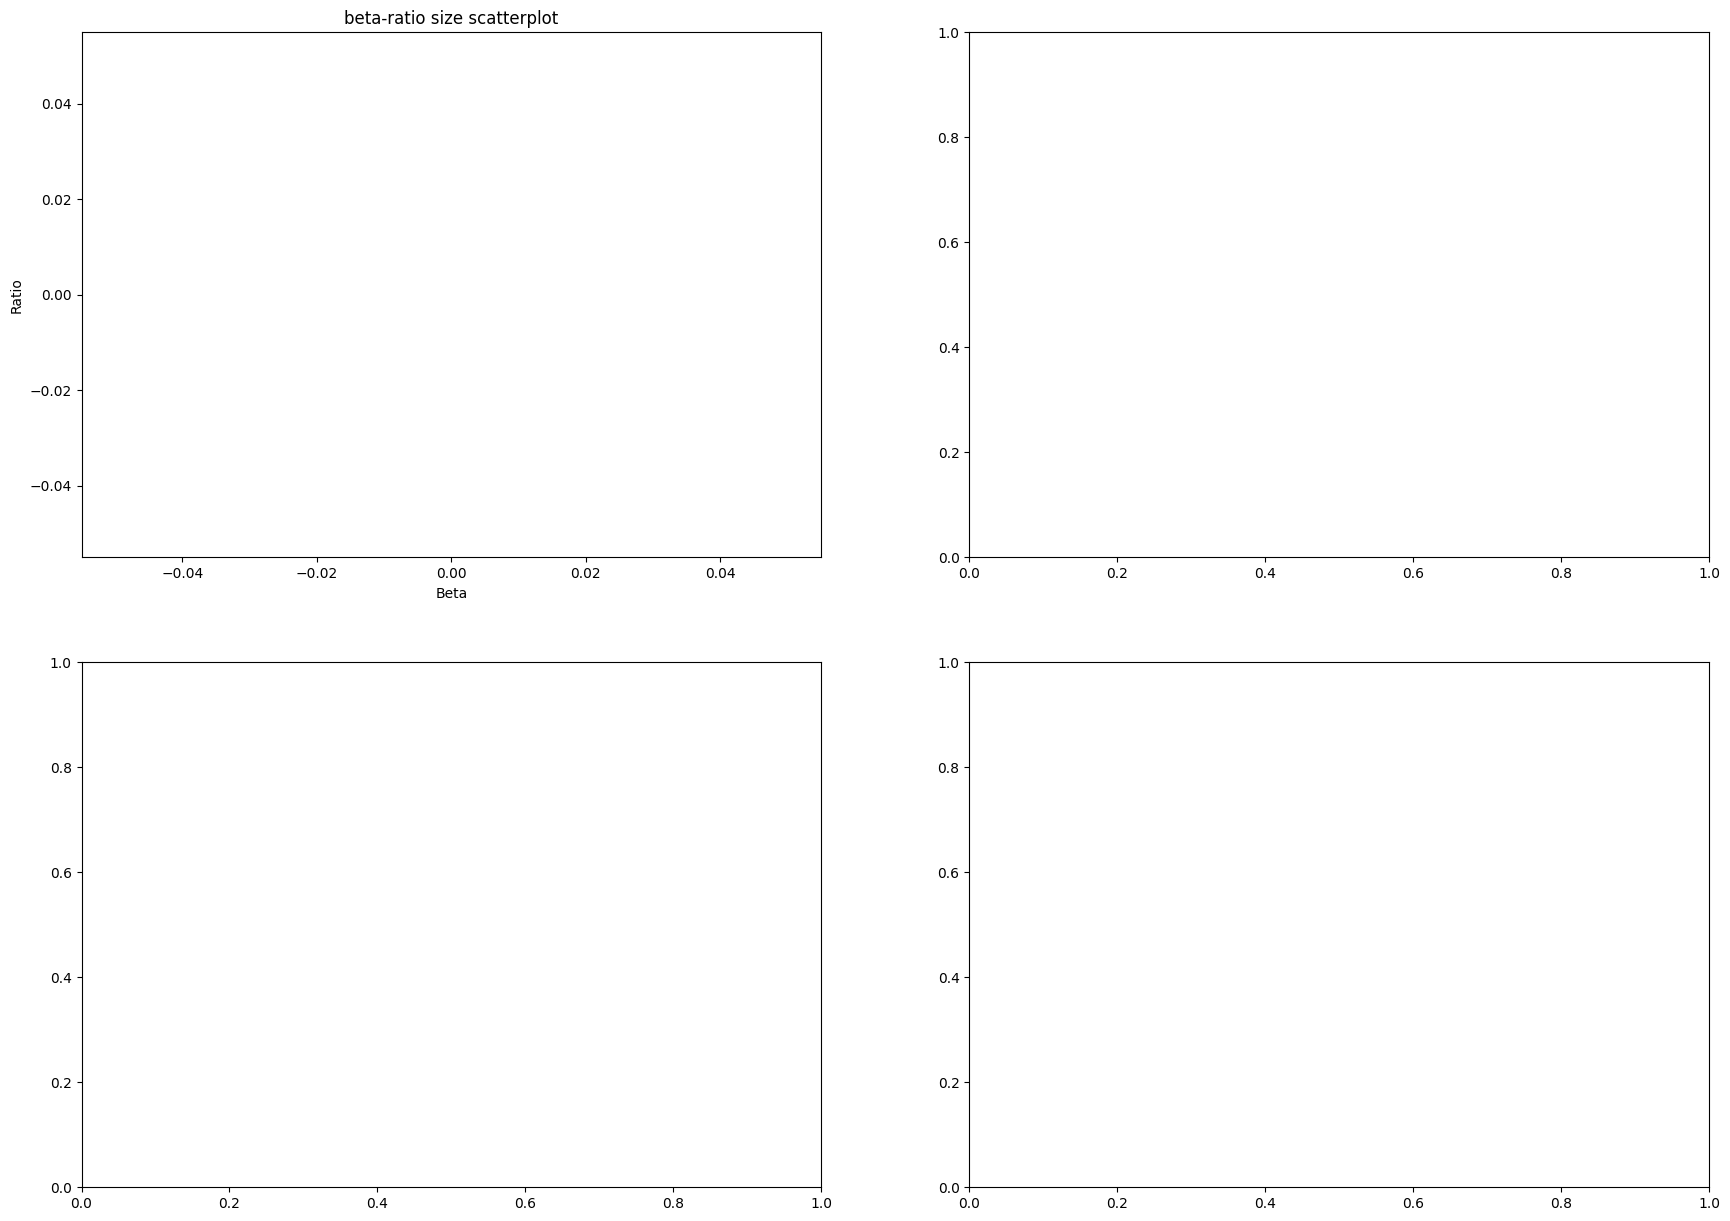

In [ ]:
#plot scatterplots

fig, axes = plt.subplots(2, 2, figsize=(21, 15))

beta_df

##
axes[0,0].set_title('beta-ratio size scatterplot')
axes[0,0].plot(beta_df[:,0], beta_df[:,1])

#Formatting
axes[0,0].set_xlabel('Beta')
axes[0,0].set_ylabel('Ratio')


## Study the dependence between birth size noise and the molecule number


### Simulation


In [ ]:
# Simulation Parameters
n_lineages = 100 #number of lineages
n_steps = 10000 # simulation steps
n_observables_time_series = 3 #number of observables
n_observables_division = 7 #number of observables t_div, tau, x_o, x_f, s_o, s_f, x_*

study_data = np.zeros((18,3))

for i, (_x_noise, _molecule_number) in enumerate(itertools.product([1,5,10],[50, 100, 500, 1000, 5000, 10000])):

    s_start = 10  # Initial cell size
    x_start = _molecule_number # Initial molecule number

    lineages_time_series, data_divisions = simulation(
      molecular_dynamics = "stochastic",
      molecular_threshold = "stochastic",
      reset = 0,
      x_start = 0.5 * _molecule_number,
      x_thresh = _molecule_number,
      x_abs_noise = _x_noise,
      s_start = s_start,
      alpha = alpha,
      n_lineages = n_lineages,
      n_steps = n_steps,
      n_observables_time_series = n_observables_time_series,
      n_observables_division = n_observables_division,
      nu = nu,
      mu = mu,
      lambda_ = lambda_
    )

    _noise = np.sqrt(np.var(data_divisions[4,:]))/np.mean(data_divisions[4,:])

    study_data[i,:] = np.array([_x_noise, _molecule_number, _noise])

    print(np.array([_x_noise, _molecule_number, _noise]))
















[ 1.         50.          0.10183792]
[  1.         100.           0.11279274]
[1.00000000e+00 5.00000000e+02 2.85142138e-01]
[1.00000000e+00 1.00000000e+03 4.27363194e-01]
[1.00000000e+00 5.00000000e+03 9.25264484e-01]
[1.e+00 1.e+04 0.e+00]
[ 5.         50.          0.10159338]
[  5.         100.           0.11085142]
[5.00000000e+00 5.00000000e+02 2.85544163e-01]
[5.00000000e+00 1.00000000e+03 4.27503507e-01]
[5.0000000e+00 5.0000000e+03 9.2493451e-01]
[5.e+00 1.e+04 0.e+00]
[10.         50.          0.10004228]
[ 10.         100.           0.11220424]
[1.00000000e+01 5.00000000e+02 2.84628628e-01]
[1.00000000e+01 1.00000000e+03 4.28010451e-01]
[1.00000000e+01 5.00000000e+03 9.25262428e-01]
[   10. 10000.     0.]


In [ ]:
df = pd.DataFrame(study_data)
# Save DataFrame to CSV
df.to_csv("array_data.csv")